In [263]:
import os
import pickle
import numpy as np
import pandas as pd
from glob import glob
import sqlalchemy as sql
from tqdm import tqdm_notebook
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib notebook

In [35]:
column_names = pd.read_csv('column_names.txt').columns

What does SVT look like, how can we query and identify it (do I need 2sec data to identify jump? just identify dsn and day that I would need, have to get the 2 sec data from BinaryMask folders. May take too long though if there are > 20,000 cases..)

    instantaneous jump in HR
    for 10? seconds
    jumps from 'normal'(depends on age of baby) to over 220
    
try machine learning?..don't actually have a lot of 'labeled' data

In [26]:
folder = '16k_round_2'

In [ ]:
# Load the dsns df, resample by day and keep max and count how many have HR_max > 220
# dsn_num_high_hr = {}
# for dsn in tqdm_notebook(dsn_list):
#     df_all = pickle.load(open(f'/Users/brodriguez/Documents/Owlet-code/16k_round_2/16000_dfs/{dsn}_df.p', 'rb'))
#     # Resample keep max
#     df_all = df_all.resample('D').max()
#     dsn_num_high_hr[dsn] = sum(df_all.heart_rate_raw_max.ge(220))

In [2]:
# pickle.dump(dsn_num_high_hr, open('dsn_num_high_hr.p','wb'))
# dsn_num_high_hr = pickle.load(open('dsn_num_high_hr.p','rb'))

In [27]:
dsns = pickle.load(open(f'/Users/brodriguez/Documents/Owlet-code/16k_round_2/rollups_dsns.p', 'rb'))

In [28]:
inclusion_dsns = pickle.load(open(f'/Users/brodriguez/Documents/Owlet-code/16k_round_2/inclusion_dsns.p', 'rb'))

In [6]:
'AC000W000503823' in inclusion_dsns

True

In [8]:
# Maybe start with any incident where hr > 200..
likely_svt = dict()
for dsn in tqdm_notebook(dsns):
    df = pickle.load(open(f'/Volumes/baileyWD/{folder}/16000_dfs/{dsn}_df.p', 'rb'))
    resample = df[['heart_rate_raw_min', 'heart_rate_raw_max']].resample('D')
    df_day_max = resample.max()
    df_day_min = resample.min()
    svt_days = list(df_day_min.loc[(df_day_max.heart_rate_raw_max > 220) & (df_day_min.heart_rate_raw_min < 180)].index)
    if len(svt_days) > 0:
        likely_svt[dsn] = svt_days# list of days when there is a possible SVT episode

In [10]:
# pickle.dump(likely_svt, open('likely_svt_220.p', 'wb'))

In [29]:
likely_svt = pickle.load(open('likely_svt_220.p', 'rb'))

In [8]:
len(likely_svt.keys())

6328

In [10]:
count = 0
for key, value in likely_svt.items():
    count += len(value)

In [11]:
count # Could Maybe look at 2 sec for all these; 
    #possibly ~2 hours to run something if there were 20000 cases for the 16000 dsns

19122

In [32]:
def load_2_sec(dsn, folder, day):
    day = str(day.date()).replace('-', '')
    filename = f'/Volumes/baileyWD/TwoSecondSockMask{folder}/{dsn}/{dsn}_{day}.csv.gz'
    df = pd.read_csv(filename, compression='gzip', names=column_names)
    df.drop_duplicates('timestamp')
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df = df.sort_values(by=['timestamp'])
    df = df.reset_index(drop=True)
    return df

def find_folder(dsn, folder_dsns):
    for num in [9,10,11,12,13,14,15,16]:
        if dsn in folder_dsns[f'BinaryMask{num}']:
            return num

        
def baby_age(day, baby_df):
    '''Use most recently reported unless you dont know when 1 was reported'''
    # Still would need to modify the birthday data to have a column with the reported date
    relevant_birthdays = baby_df.loc[baby_df.created_at <= str(day)] # What was reported before the last use
    if relevant_birthdays.shape[0] == 0:
        return pd.Timedelta(days=-1), ''
    else:
        # Use the last reported bday
        last_reported = max(relevant_birthdays.created_at.values)
        bday = relevant_birthdays.query('created_at == @last_reported').birthDate.values[0]
    
    age = day.date() - date(int(bday[:4]), int(bday[4:6]), int(bday[6:]))
    return age, bday

def in_US(day, location_df):
    '''Return True if device was used in the US'''
    location = location_df.loc[location_df.created_at <= str(day)]
    if location.shape[0] == 0:
        # Don't know the location
        return False
    elif location.cc.iloc[-1] != 'US':
        return False
    else:
        return True

def num_notifications(df, x):
    "Where the base state changes to x"
    value = df.base_state.eq(x)
    indices = np.ndarray.flatten(np.argwhere(value))
    differences = np.diff(indices)
    if len(indices) != 0:
        differences = np.insert(differences, 0, 0)
    final_indices = list(np.ndarray.flatten(np.argwhere(differences != 1)))
    return indices[final_indices]

def largest_jump(df):
    # look at biggest jump?
    diff = df.loc[df.heart_rate_raw > 0].heart_rate_raw.diff()
    return diff.max()

def longest_episode(df):
    # len of longest episode (time that HR > 240)
    episodes = df.loc[df.heart_rate_raw > 0].heart_rate_raw > 240
    lengths = [-1] + list(np.ndarray.flatten(np.argwhere(~episodes))) + [len(episodes)]
    diff = np.diff(lengths)
    ## seconds
    seconds = 2*(max(diff) - 1)
    return seconds # seconds, minutes, or hours?

def count_valid(df):
    df = df.loc[(df.notification_mask == 0) & (df.heart_rate_raw >= 240)]
    return df.shape[0]

# Function for checking 2 sec data for SVT, use try except for getting 2sec data from drive?
def check_SVT(likely_svt, baby_info, folder_dsns, locations):
    rows = []
    missed = []
    # load 2 sec data if I have it
    for dsn, days in tqdm_notebook(likely_svt.items()):
        folder = find_folder(dsn, folder_dsns)
        dsn_location = locations.loc[locations.dsn == dsn]
        for day in days:
            if (str(day) > '2017-01-31') & (str(day) < '2019-02-01'):
                try:
                    df = load_2_sec(dsn, folder, day)
                    if df.shape[0] > 0:
                        age, b_day = baby_age(day, baby_info.loc[baby_info.dsn == dsn])
                        if (age >= pd.Timedelta(days=0)) & (age < pd.Timedelta(days=365)):
                            if in_US(day, dsn_location):
                                jump = largest_jump(df)
                                max_hr = df.heart_rate_raw.max() # raw or avg??
                                episode = longest_episode(df) # len of longest?..
                                num_notif = len(num_notifications(df, 12))
                                valid = count_valid(df)
                                # How many valid points is HR > 240?
                                # Added birthday to distinguish different babies on 1 device
                                rows.append((dsn, b_day, day.date(), max_hr, jump, episode, age, num_notif, valid))
                        
                except Exception as e:
                    print(e)
                    missed.append(dsn + ': ' + str(day))
            
    
    df_columns = ['dsn','birthdate','date','max_hr','largest_jump','longest_episode','baby_age','red_alerts','valid']
    full_df = pd.DataFrame(rows, columns=df_columns)
    return full_df, missed


def monitoring_age(dsn_list, baby_info):
    # Don't care about charging data
    rows = []
    for dsn in tqdm_notebook(dsn_list):
#         files = glob(f'/Volumes/baileyWD/16k_round_2/16000_dfs/{dsn}') # would need 2 sec
        df_10min = pickle.load(open(f'/Volumes/baileyWD/16k_round_2/16000_dfs/{dsn}_df.p', 'rb'))
        df_days = list(df_10min.index.normalize().unique())
        
        for day in df_days:
            age, b_day = baby_age(day, baby_info.loc[baby_info.dsn == dsn])
            rows.append((dsn, day.date(), b_day, age))
    
    df_columns = ['dsn', 'date', 'birthdate', 'age']
    return pd.DataFrame(rows, columns=df_columns)

In [33]:
inclusion_svt = inclusion_dsns.intersection(list(likely_svt.keys()))

ROUND 1: Of **10932** Inclusion dsns, **4523** had at least 1 day with the heart rate above 220

In [36]:
folder = '16k_round_2'
folder_dsns = pickle.load(open('folder_dsns.p', 'rb'))
baby_info = pickle.load(open('16k_reg_and_cc_bdays4.p','rb'))
locations = pickle.load(open(f'/Users/brodriguez/Documents/Owlet-code/{folder}/16000_location_data.p', 'rb'))
full_df, missed = check_SVT({dsn: likely_svt[dsn] for dsn in list(inclusion_svt)},baby_info, folder_dsns, locations)

/Users/brodriguez/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [37]:
full_df = full_df.loc[full_df.longest_episode > 0]
full_df['valid_percent'] = (full_df.valid * 2) / full_df.longest_episode

In [38]:
# pickle.dump(full_df, open('svt_round2_stats.p','wb'))
full_df = pickle.load(open('svt_round2_stats.p', 'rb'))

In [39]:
# (need to be in US and < 1 yr)
full_df#[(full_df.baby_age < pd.Timedelta(days=0))]#.dsn.value_counts()

,dsn,birthdate,date,max_hr,largest_jump,longest_episode,baby_age,red_alerts,valid,valid_percent
0,AC000W002450411,20180914,2018-10-27,292,148.0,452,43 days,0,18,0.079646
2,AC000W001139906,20170823,2017-09-08,264,88.0,2,16 days,0,2,2.000000
3,AC000W001139906,20170823,2017-09-09,244,108.0,6,17 days,0,2,0.666667
4,AC000W001139906,20170823,2017-09-18,252,120.0,34,26 days,1,4,0.235294
5,AC000W001139906,20170823,2017-09-28,256,80.0,38,36 days,0,7,0.368421
7,AC000W001090297,20170919,2017-10-27,276,44.0,6,38 days,1,3,1.000000
9,AC000W001205325,20171120,2017-12-03,280,148.0,282,13 days,2,10,0.070922
10,AC000W001205325,20171130,2017-12-06,252,116.0,74,6 days,1,4,0.108108
22,AC000W001205325,20171130,2018-02-11,280,96.0,12,73 days,1,6,1.000000
23,AC000W001205325,20171130,2018-02-25,288,128.0,204,87 days,2,75,0.735294


In [461]:
# df_test = pd.read_csv('/Volumes/baileyWD/TwoSecondSockMask10/AC000W000104360/AC000W000104360_20180626.csv.gz', compression='gzip',names=column_names)
# df_test = pickle.load(open(f'/Volumes/baileyWD/16k_round_2/16000_dfs/AC000W001088961_df.p', 'rb'))


In [339]:
# df_test[df_test.heart_rate_raw > 200]#.heart_rate_avg.diff().max()

# SVT for non premature (using SQL database on bigmama)

In [272]:
non_premature_dsns = pickle.load(open('one_entry_non_premature_dsns.p','rb'))
valid_gestation = pickle.load(open('valid_gestation.p','rb'))

Exclusions

In [316]:
after_feb_2017 = valid_gestation.loc[(valid_gestation.birthDate >= date(2017,2,1)) & (valid_gestation.birthDate < date(2019,2,1))]


In [320]:
inclusion_dsns = list((after_feb_2017[after_feb_2017.week_of_birth >= 38].dsn.value_counts() == 1).index)

In [324]:
location_data = pd.read_csv('/Users/brodriguez/Documents/Owlet-code/GPS_locations_Mar_2019.csv', compression='gzip')
# def dsn_include(x):
#     if x['dsn'] in inclusion_dsns:
#         return True
#     else:
#         return False
# include = location_data.apply(dsn_include, axis=1)
# location_data = location_data.loc[include].sort_values(by='created_at')
# pickle.dump(location_data, open(f'non_premature_locations.p', 'wb'))

In [325]:
def in_US(bday, location_df):
    '''Return True if device was used in the US'''
    location = location_df.loc[location_df.created_at >= str(bday)]
    if location.shape[0] == 0:
        # Don't know the location
        return False
    elif location.cc.iloc[-1] != 'US':
        return False
    else:
        return True 

In [ ]:
1+1

In [326]:
final_inclusion = []
for dsn in tqdm_notebook(inclusion_dsns):
    bday = valid_gestation.loc[valid_gestation.dsn == dsn].birthDate.values[0]
    if in_US(bday,location_data.loc[location_data.dsn == dsn]):
        final_inclusion.append(dsn)

In [327]:
pickle.dump(final_inclusion, open('final_svt_inclusion.p','wb'))

In [328]:
len(final_inclusion)

59963

Connect to database

In [329]:
DB_USER = 'brodriguez'
DB_PASSWORD = input()
DB_CONN = 'localhost'
DB_NAME = 'owletsock'
# SQL login
s = f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_CONN}/{DB_NAME}'
engine = sql.create_engine(s)
conn = engine.connect()

letmein


In [ ]:
possible_svt = dict()
no_data = []
for dsn in tqdm_notebook(final_inclusion):
    df = pd.read_sql("""select * from tenminsock where dsn = %(d)s""", conn, params={'d':dsn})
    if df.shape[0] == 0:
        no_data.append(dsn)
    else:
        # Need to take data after birthday and before age 1..
        birthday = valid_gestation.loc[valid_gestation.dsn == dsn].birthDate.values[0]
        one_year = birthday + pd.Timedelta(days=365)
        df = df.loc[(df.TimeWindowStartTime >= birthday) & (df.TimeWindowStartTime < one_year)]
        if df.shape[0] == 0:
            no_data.append(dsn)
        else:
            df.set_index('TimeWindowStartTime', inplace=True)
            resample = df[['HeartRateRawMin', 'HeartRateRawMax']].resample('D')
            df_day_max = resample.max()
            df_day_min = resample.min()
            svt_days = list(df_day_min.loc[(df_day_max.HeartRateRawMax > 220) & (df_day_min.HeartRateRawMin < 180)].index)
            if len(svt_days) > 0:
                possible_svt[dsn] = svt_days# list of days when there is a possible SVT episode
                

/Users/brodriguez/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
pickle.dump(possible_svt, open('possible_svt_60k.p','wb'))

need 2 sec data

Disconnect from database

In [314]:
conn.close()

## Plots

In [ ]:
    # Group by dsn, birthdate to get individual babies 
    # WHY ARE THERE INSTANCES OF HR > 310???
    
# Histogram showing how long the first SVT episode lasts for each baby

# Histogram showing the total number of SVT episodes per baby

# Age vs SVT

# How long between SVT episodes

In [142]:
# valid_percent or valid.. valid gives # of valid readings >= 240
df_svt = full_df.loc[((full_df.longest_episode >= 10) | (full_df.largest_jump >=80)) & (full_df.valid >= 10) & (full_df.max_hr <= 310) & (full_df.max_hr >= 240)]
df_svt.baby_age = df_svt.baby_age.apply(lambda x: x.days)


/Users/brodriguez/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [143]:
df_svt = df_svt.sort_values(by=['dsn','date'])
first_instance = df_svt.drop_duplicates(['dsn', 'birthdate'])
babies = first_instance.shape[0]
incidents = df_svt.shape[0]
total_babies_possible_svt = full_df.drop_duplicates(['dsn', 'birthdate']).shape[0]

In [220]:
df_svt # 789/1673 47% of these SVT cases happened while monitoring was off

,dsn,birthdate,date,max_hr,largest_jump,longest_episode,baby_age,red_alerts,valid,valid_percent
9872,AC000W000022700,20180906,2018-09-20,292,184.0,132,14,0,67,1.015152
9873,AC000W000022700,20180906,2018-09-21,272,112.0,32,15,0,21,1.312500
9874,AC000W000022700,20180906,2018-09-23,272,140.0,68,17,0,29,0.852941
6961,AC000W000023774,20180112,2018-02-27,284,60.0,20,46,1,13,1.300000
4669,AC000W000098115,20170515,2017-10-23,288,164.0,14566,161,0,48,0.006591
9389,AC000W000105146,20170502,2017-07-02,268,132.0,154,61,1,45,0.584416
9391,AC000W000105146,20170502,2018-01-05,272,132.0,9140,248,0,40,0.008753
3850,AC000W000105490,20180201,2018-02-08,264,84.0,320,7,0,32,0.200000
535,AC000W000106381,20170904,2017-11-14,272,84.0,46,71,0,32,1.391304
9082,AC000W000236263,20171226,2018-01-16,244,100.0,16,21,0,10,1.250000


In [144]:
babies

816

In [50]:
total_babies_possible_svt

4142

In [52]:
len(inclusion_dsns) # But how many babies does this correspond to

10932

In [261]:
df_svt.loc[df_svt.longest_episode > 60000] # Don't make sense.. 3 had sock off

,dsn,birthdate,date,max_hr,largest_jump,longest_episode,baby_age,red_alerts,valid,valid_percent
5833,AC000W000423702,20170831,2017-09-21,296,144.0,63184,21,1,13,0.000411
1532,AC000W001111723,20171201,2018-03-05,252,144.0,66820,94,2,36,0.001078
4916,AC000W002424163,20170930,2017-11-02,288,156.0,61704,33,8,234,0.007585
2770,AC000W002692033,20180919,2018-10-09,288,168.0,74124,20,6,63,0.001700


In [44]:
# df_svt.loc[(df_svt.valid_percent < .3) & (df_svt.longest_episode > 1000)]

In [32]:
full_df.dsn.value_counts()

AC000W001096325    109
AC000W001123356     45
AC000W001137930     39
AC000W001098068     38
AC000W001205325     36
AC000W001154135     36
AC000W001215256     35
AC000W001115934     34
AC000W001111257     32
AC000W001088961     32
AC000W001144263     29
AC000W002674489     29
AC000W001111723     27
AC000W002428925     27
AC000W001134061     27
AC000W001181066     26
AC000W001068025     25
AC000W001134059     24
AC000W002671581     24
AC000W001084435     23
AC000W001133350     23
AC000W001047793     23
AC000W001100293     22
AC000W001139301     22
AC000W001138547     22
AC000W001133558     22
AC000W001095356     20
AC000W001056098     20
AC000W001127836     20
AC000W001056136     19
                  ... 
AC000W002600738      1
AC000W001096469      1
AC000W001110671      1
AC000W003382895      1
AC000W001153679      1
AC000W002450206      1
AC000W002623449      1
AC000W001110477      1
AC000W002450755      1
AC000W001062925      1
AC000W001208425      1
AC000W002580264      1
AC000W00115

<IPython.core.display.Javascript object>


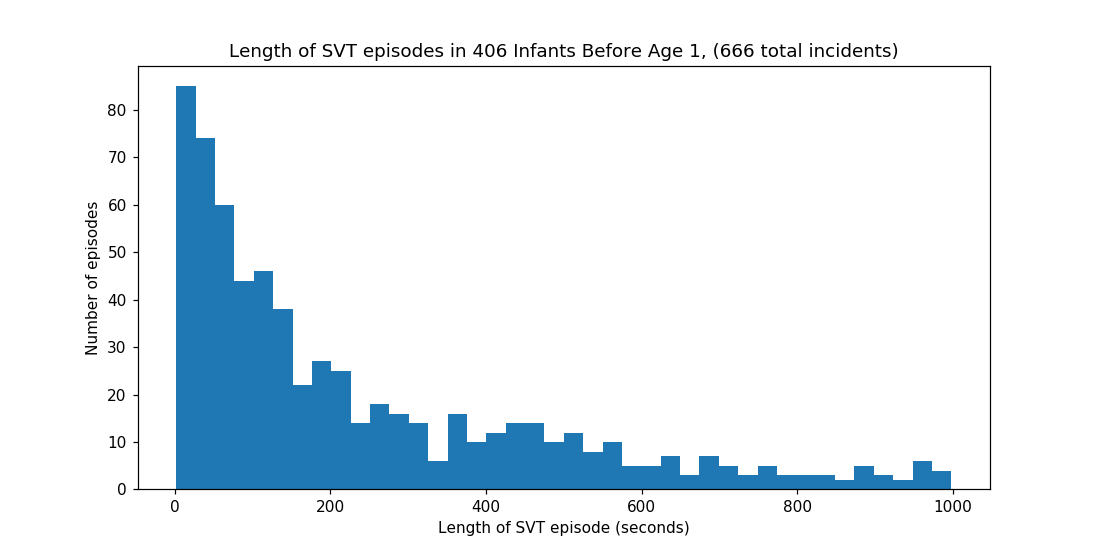

Text(0.5, 1.0, 'Length of SVT episodes in 406 Infants Before Age 1, (666 total incidents)')

In [203]:
# Need to make sure that the episodes that I'm looking at are valid (sock on, enough valid data points etc...)
plt.hist(df_svt.loc[(df_svt.longest_episode < 1000) & (df_svt.red_alerts == 0)].longest_episode, bins=40)
incidents = df_svt.loc[(df_svt.longest_episode < 1000) & (df_svt.red_alerts == 0)].shape[0]
babies_no_monitoring = df_svt.loc[(df_svt.longest_episode < 1000) & (df_svt.red_alerts == 0)].dsn.value_counts().shape[0]
plt.xlabel("Length of SVT episode (seconds)")
plt.ylabel("Number of episodes")
plt.title(f"Length of SVT episodes in {babies_no_monitoring:,} Infants Before Age 1, ({incidents:,} total incidents)")
# Look at those that did not get red notifications (data less likely to get interrupted)

<IPython.core.display.Javascript object>


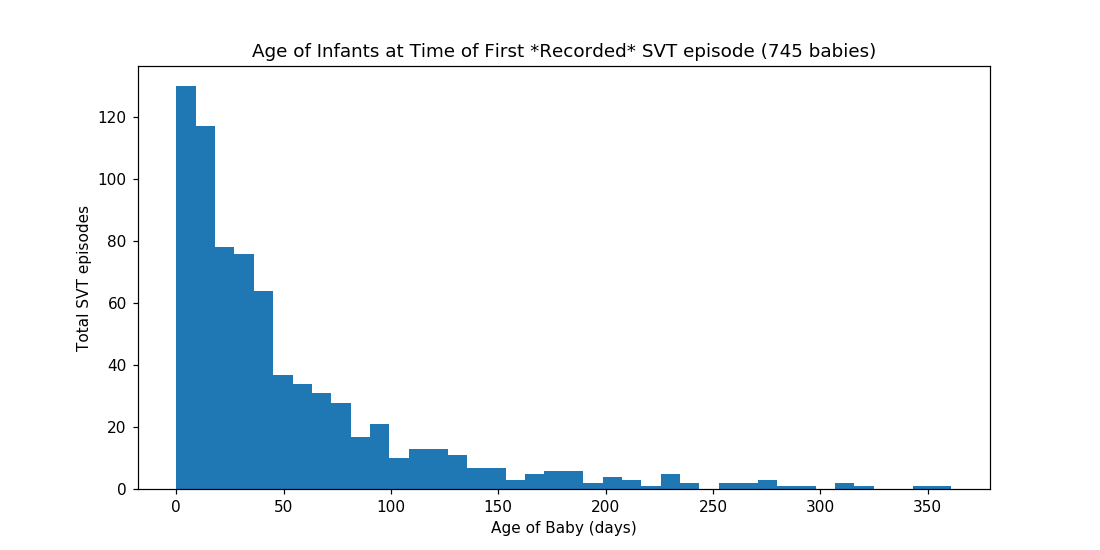

Text(0.5, 1.0, 'Age of Infants at Time of First *Recorded* SVT episode (745 babies)')

In [83]:
plt.hist(first_instance.baby_age, bins=40)
plt.xlabel("Age of Baby (days)")
plt.ylabel("Total SVT episodes")
plt.title(f"Age of Infants at Time of First *Recorded* SVT episode ({babies:,} babies)")

<IPython.core.display.Javascript object>


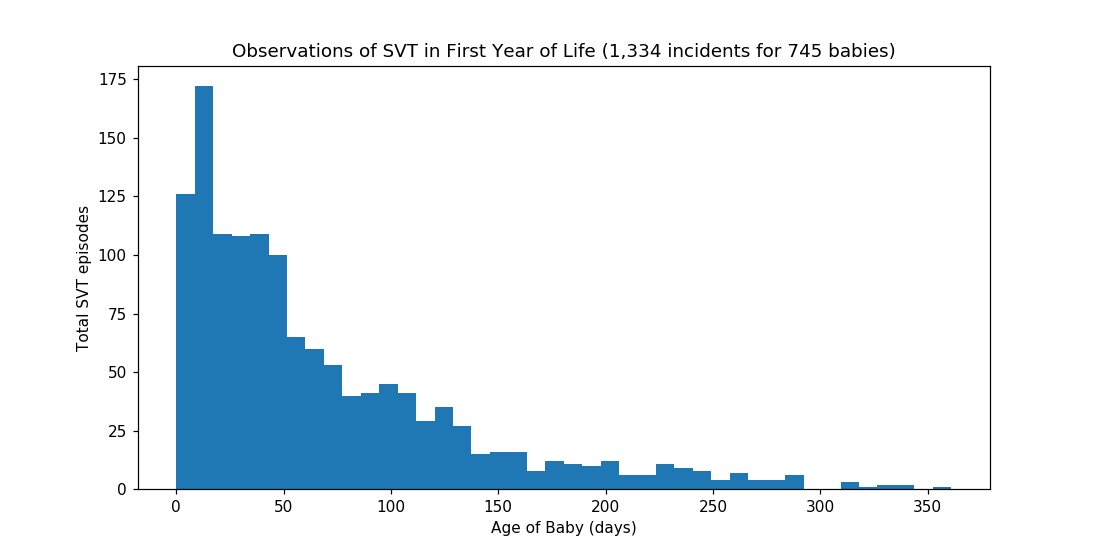

Text(0.5, 1.0, 'Observations of SVT in First Year of Life (1,334 incidents for 745 babies)')

In [86]:
plt.hist(df_svt.baby_age, bins=42)
plt.xlabel("Age of Baby (days)")
plt.ylabel("Total SVT episodes")
plt.title(f"Observations of SVT in First Year of Life ({incidents:,} incidents for {babies:,} babies)")
# control for usage (percentage based on how many babies were actually being observed)

In [166]:
#need baby age, # with SVT/total 
days_in_first_year = [pd.Timedelta(days = i) for i in range(365)]
df_days_year1 = pd.DataFrame(days_in_first_year, columns=['baby_age'])

In [185]:
def get_percent(x):
    svt = df_svt[df_svt.baby_age == x.days].shape[0]
    all_ = monitoring_inclusion[monitoring_inclusion.age == x].shape[0]
    if all_ == 0:
        return 0
    return svt/all_
    
df_days_year1['percent_SVT'] = df_days_year1.baby_age.apply(get_percent)

<IPython.core.display.Javascript object>


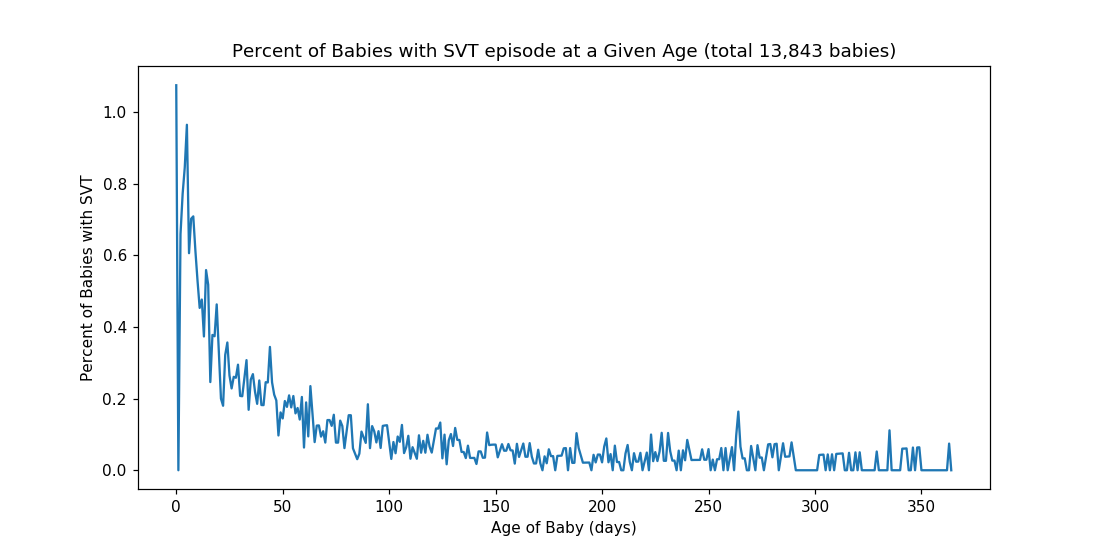

Text(0.5, 1.0, 'Percent of Babies with SVT episode at a Given Age (total 13,843 babies)')

In [204]:
plt.plot([day.days for day in list(df_days_year1.baby_age)],df_days_year1.percent_SVT.values*100)
plt.xlabel("Age of Baby (days)")
plt.ylabel("Percent of Babies with SVT")
plt.title(f"Percent of Babies with SVT episode at a Given Age (total {monitored_babies:,} babies)")

In [192]:
def get_percent_first(x):
    svt = first_instance[first_instance.baby_age == x.days].shape[0]
    all_ = monitoring_inclusion[monitoring_inclusion.age == x].shape[0]
    if all_ == 0:
        return 0
    return svt/all_
df_days_year1['percent_first_SVT'] = df_days_year1.baby_age.apply(get_percent_first)

<IPython.core.display.Javascript object>


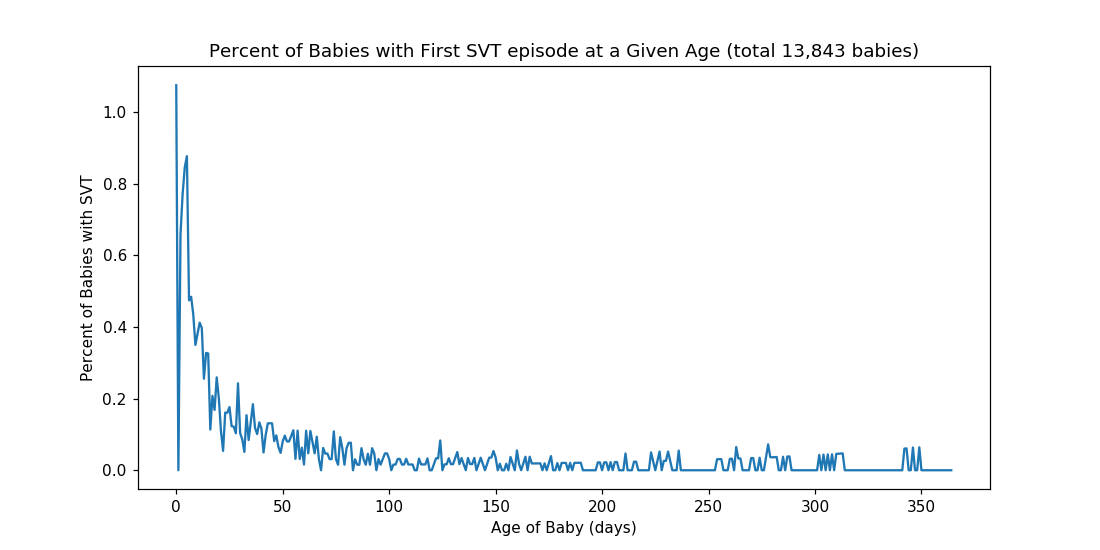

Text(0.5, 1.0, 'Percent of Babies with First SVT episode at a Given Age (total 13,843 babies)')

In [194]:
plt.plot([day.days for day in list(df_days_year1.baby_age)],df_days_year1.percent_first_SVT.values*100)
plt.xlabel("Age of Baby (days)")
plt.ylabel("Percent of Babies with SVT")
plt.title(f"Percent of Babies with First SVT episode at a Given Age (total {monitored_babies:,} babies)")

In [72]:
# dsns_unique = list(set(df_svt.dsn.values))
# monitoring = monitoring_age(dsns, baby_info) # To do with more dsns: run overnight
# do with inclusion dsns or all 16000?

In [23]:
# pickle.dump(monitoring_inclusion, open('monitoring_16k2.p','wb'))

In [118]:
monitoring_inclusion = pickle.load(open('monitoring_16k2.p','rb'))

In [120]:
# ONLY want age > -1 and < 365
# monitoring_inclusion = monitoring.loc[(monitoring.age < pd.Timedelta(days=365)) & (monitoring.age >= pd.Timedelta(days=0))]


<IPython.core.display.Javascript object>


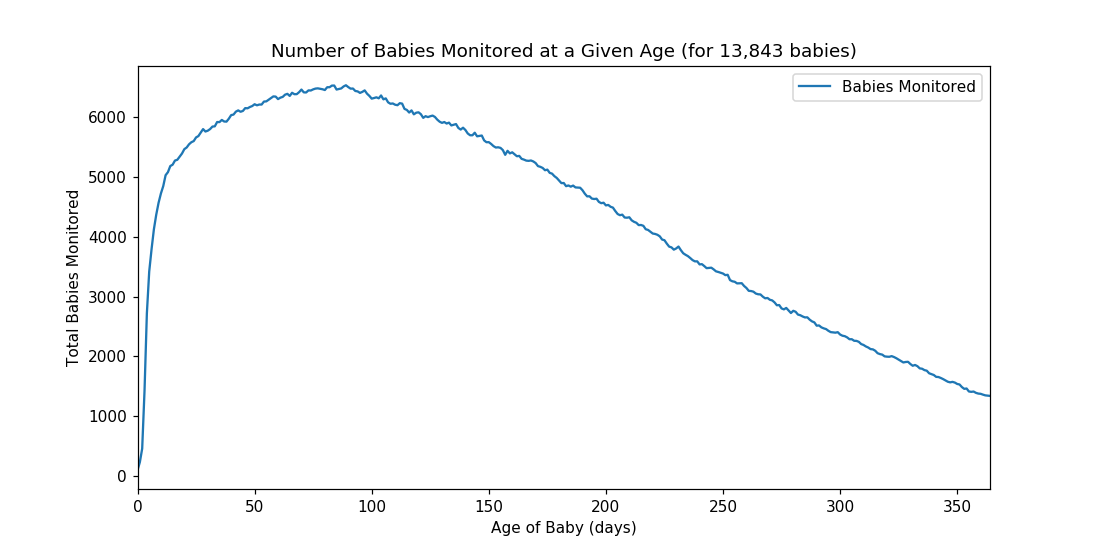

Text(0.5, 1.0, 'Number of Babies Monitored at a Given Age (for 13,843 babies)')

In [121]:
monitored_babies = monitoring_inclusion.drop_duplicates(['dsn', 'birthdate']).shape[0]

days_monitered_age = monitoring_inclusion.age.value_counts().reset_index()
days_monitered_age.columns = ['age', 'count']
days_monitered_age.age = days_monitered_age.age.apply(lambda x: x.days) # Get int for age of baby

days_monitered_age.sort_values(by='age').plot(x='age', y='count', label='Babies Monitored')

plt.xlabel("Age of Baby (days)")
plt.ylabel("Total Babies Monitored")
plt.title(f"Number of Babies Monitored at a Given Age (for {monitored_babies:,} babies)")

Would be interesting to do a plot with monitored based on age with other factors (e.g., plot # of yellow notifications with it see if there is a correlation, etc.)

In [511]:
days_monitered_age.head()

,age,count
0,82 days,1317
1,80 days,1316
2,81 days,1306
3,75 days,1297
4,77 days,1293


<IPython.core.display.Javascript object>


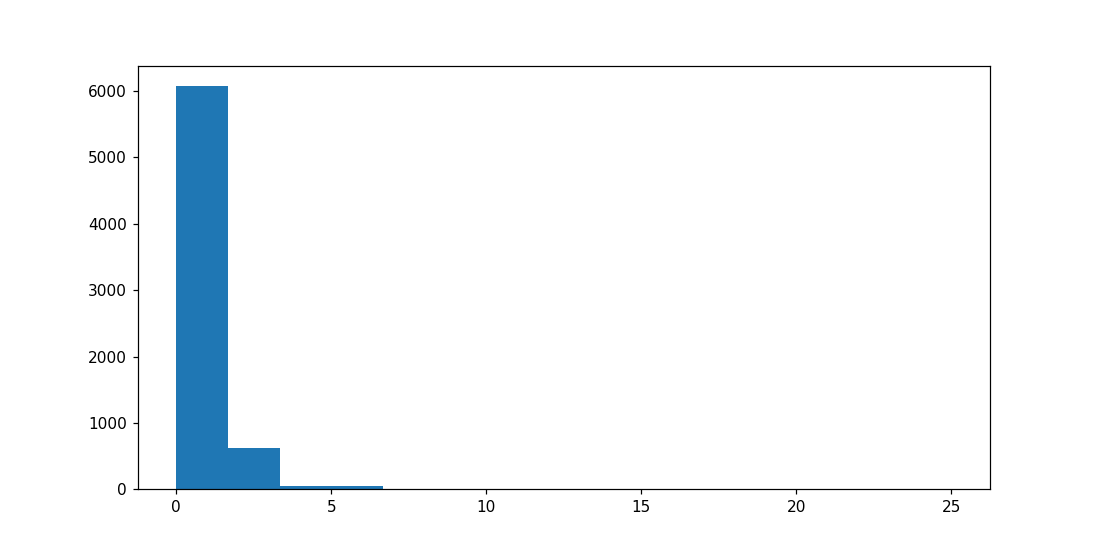

(array([6.07e+03, 6.26e+02, 4.60e+01, 4.70e+01, 1.50e+01, 3.00e+00,
        7.00e+00, 4.00e+00, 0.00e+00, 2.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00]),
 array([ 0.        ,  1.66666667,  3.33333333,  5.        ,  6.66666667,
         8.33333333, 10.        , 11.66666667, 13.33333333, 15.        ,
        16.66666667, 18.33333333, 20.        , 21.66666667, 23.33333333,
        25.        ]),
 <a list of 15 Patch objects>)

In [39]:
plt.hist(df_svt.red_alerts, bins=15)

In [74]:
multiple = df_svt.groupby(['dsn', 'birthdate']).count()

<IPython.core.display.Javascript object>


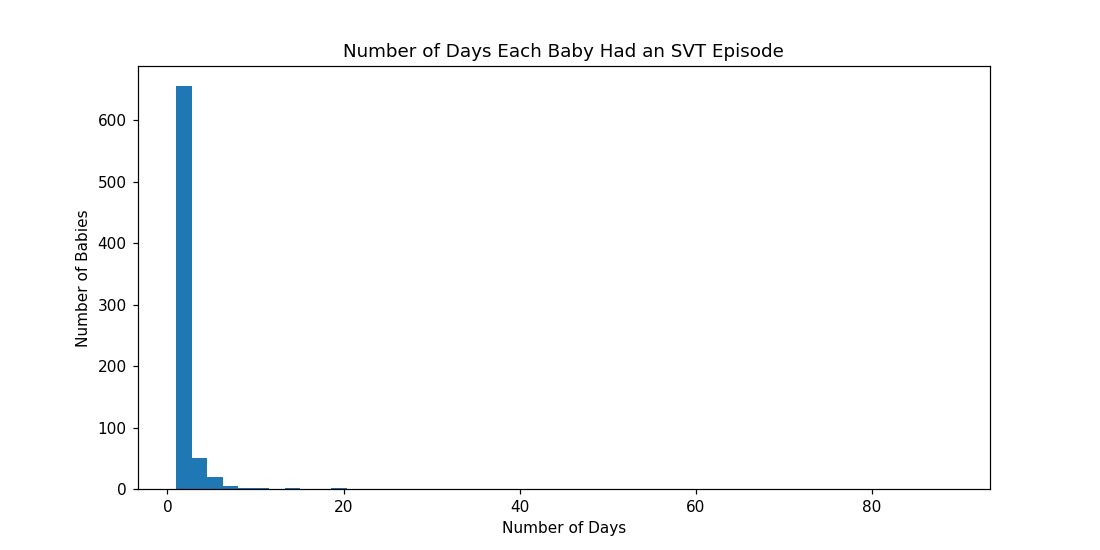

Text(0.5, 1.0, 'Number of Days Each Baby Had an SVT Episode')

In [75]:
# Try looking at > 1 episode or > 4..
plt.hist(multiple.date, bins=50)
plt.xlabel("Number of Days")
plt.ylabel("Number of Babies")
plt.title("Number of Days Each Baby Had an SVT Episode")

<IPython.core.display.Javascript object>


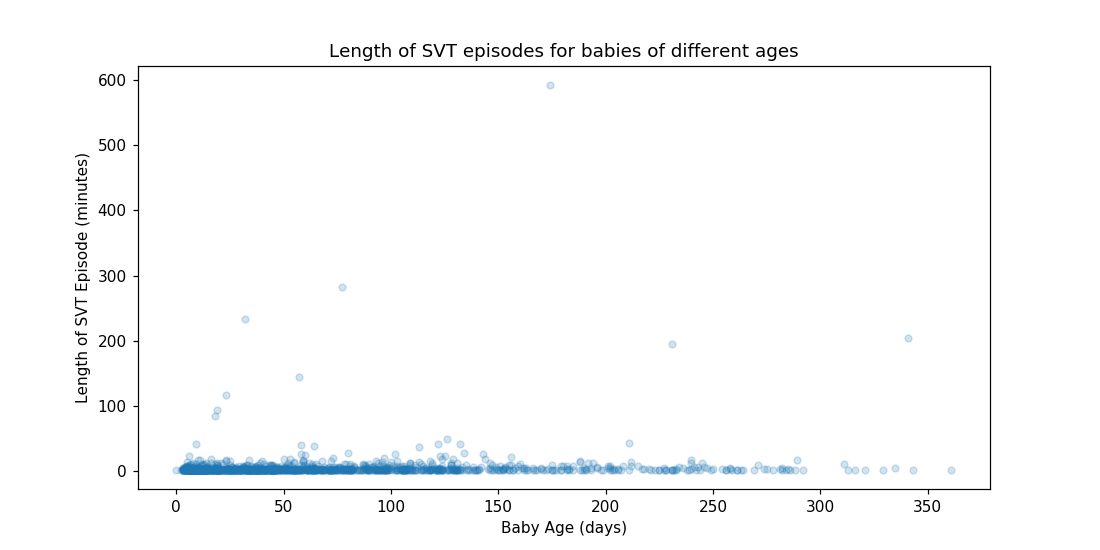

Text(0.5, 1.0, 'Length of SVT episodes for babies of different ages')

In [76]:
# age vs length?
length_in_min = df_svt[['baby_age', 'longest_episode']]
length_in_min.longest_episode = length_in_min.longest_episode.apply(lambda x: x/60)
length_in_min.plot(kind="scatter", x="baby_age", y="longest_episode", alpha=.2) # 3 far outliers
plt.xlabel("Baby Age (days)")
plt.ylabel("Length of SVT Episode (minutes)")
plt.title("Length of SVT episodes for babies of different ages")
#Convert seconds to minutes and just take out 1 outlier

<IPython.core.display.Javascript object>


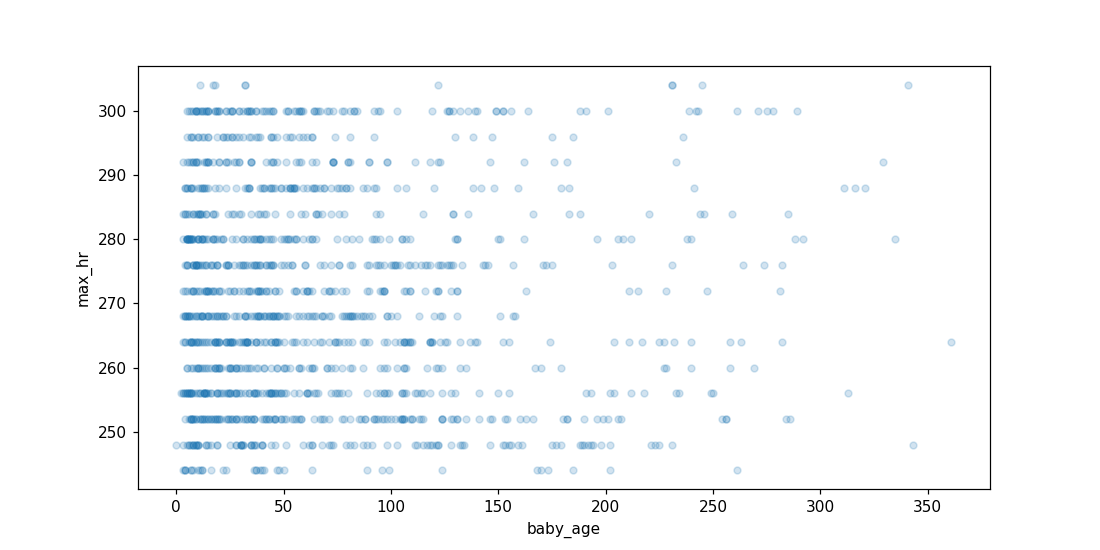

In [77]:
df_svt.plot(kind="scatter", x="baby_age", y="max_hr", alpha=.2) # 3 far outliers

<IPython.core.display.Javascript object>


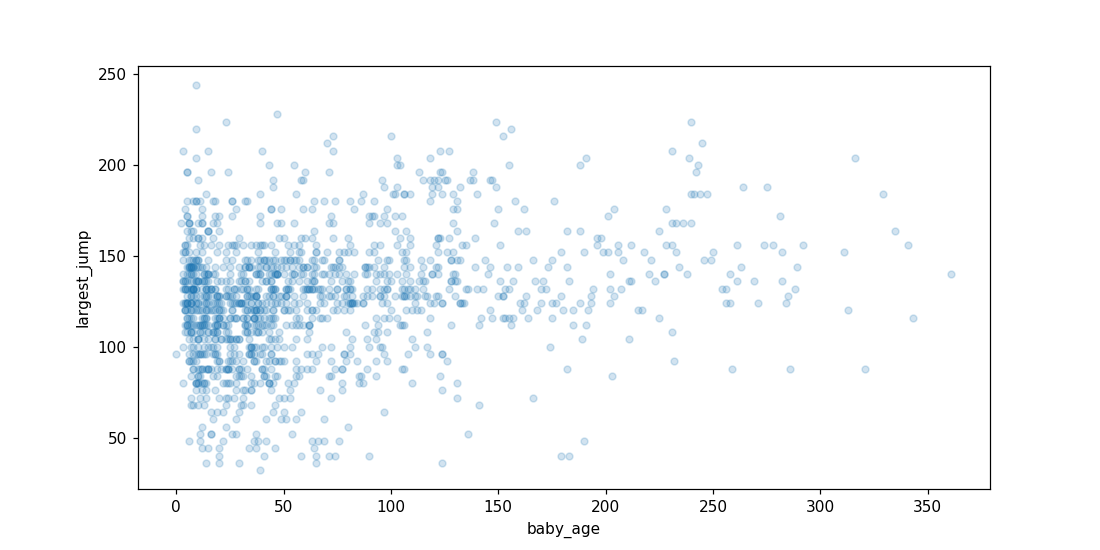

In [78]:
df_svt.plot(kind="scatter", x="baby_age", y="largest_jump", alpha=.2) # 3 far outliers

<IPython.core.display.Javascript object>


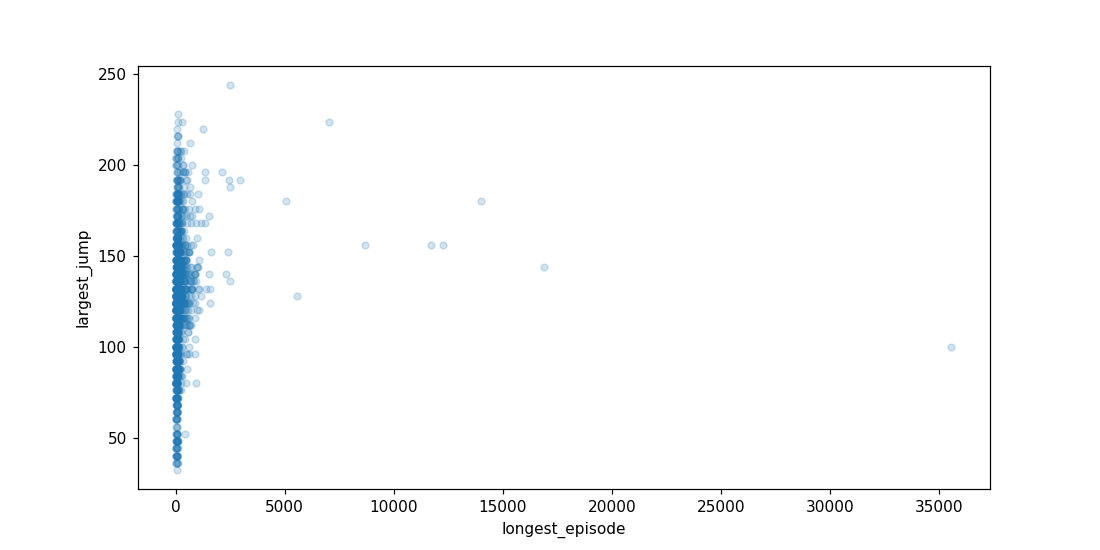

In [79]:
df_svt.plot(kind="scatter", x="longest_episode", y="largest_jump", alpha=.2)

<IPython.core.display.Javascript object>


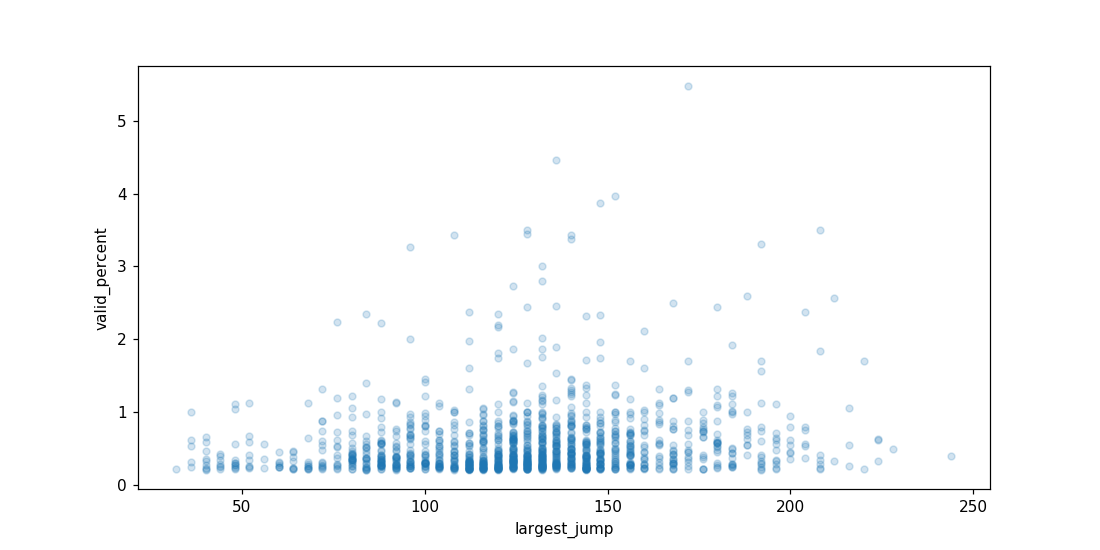

In [80]:
df_svt.plot(kind="scatter", x="largest_jump", y="valid_percent", alpha=.2)

<IPython.core.display.Javascript object>


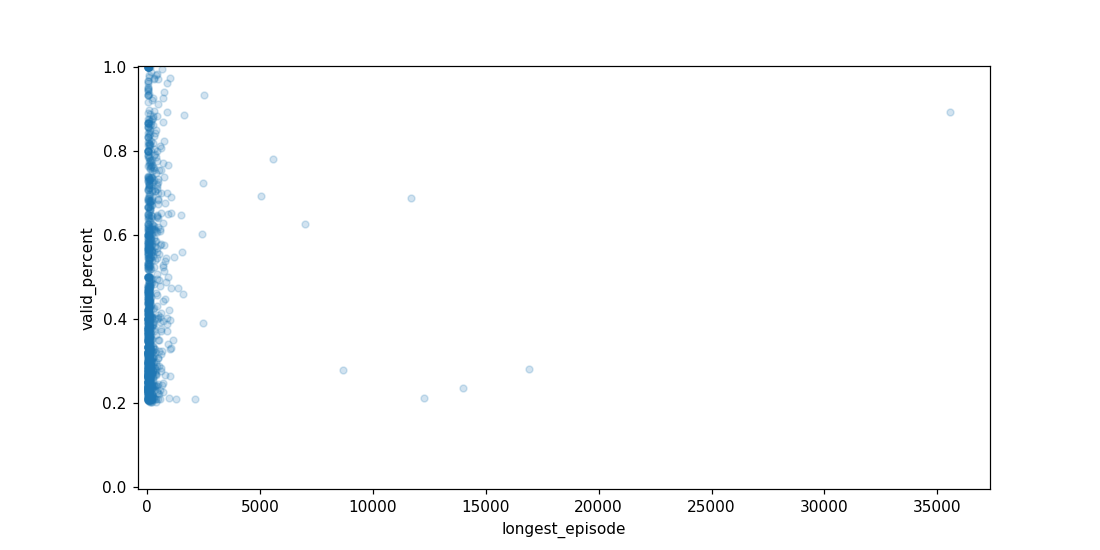

In [82]:
df_svt.plot(kind="scatter", x="longest_episode", y="valid_percent", alpha=.2)